## Afternoon practical day 3

You've just learned about convolutional neural networks. There will be a sneak peek into them at the end. For now, however, we finally implement backpropagation.



In [4]:
#run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
from numpy.random import default_rng
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display, Markdown, Math
from scipy.optimize import fmin_bfgs, fmin_cg, fmin
import sklearn

In [5]:
#important functions
def mySigmoid(data):
    data= np.array(data)
    output = 1/(1+ np.exp(-data))
    return output

def mySigmoidGradient(x):
    outcome = mySigmoid(x) * (1-mySigmoid(x))
    return outcome

def nnCostFunction(nnThetas, X, y, lambda_ = 0, inputLayerSize = 784, hiddenLayerSize = 25, classLabels = 10):
   
    m = len(X)
    
    #reshaping the list of parameters to matrices
    hiddenLayerParamNr    = (hiddenLayerSize * (inputLayerSize+1))
    thetaOneMatrix        = np.reshape(nnThetas[0:hiddenLayerParamNr],
                                       newshape = (hiddenLayerSize, inputLayerSize+1))
    outputLayerParamStart = hiddenLayerParamNr 
    thetaTwoMatrix        = np.reshape(nnThetas[outputLayerParamStart:],
                                       newshape = (classLabels, hiddenLayerSize+1))
    
    #calculating the forward pass
    inputs        = np.c_[np.ones(shape = (len(X), 1)), X]
    weightedSumHL = inputs @ thetaOneMatrix.T
    activationsHL  = mySigmoid(weightedSumHL)
    
    inputsOL      = np.c_[np.ones(shape = (len(activationsHL), 1)), activationsHL]
    weightedSumOL = inputsOL @ thetaTwoMatrix.T
    activationsOL = mySigmoid(weightedSumOL)
    
    #cost
    J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
    
    #regularised cost
    #remember: units in the rows, their parameters in the columns
    #Hence, [:,1:] removes the columns with the bias term.
    regThetaOne = np.sum(np.square(thetaOneMatrix[:,1:]))
    regThetaTwo = np.sum(np.square(thetaTwoMatrix[:,1:]))
    regCost     = J + (lambda_/(2*m)) * (regThetaOne + regThetaTwo)
    
    return regCost

def numericalGradientApproximation(nnThetas, X, y, lambda_ = 0, e = 1e-4, indexToStop = 500):
    nnThetasMinusE = nnThetas-e
    nnThetasPlusE  = nnThetas+e
    listGradients = []
    for index, value in enumerate(nnThetas):
        if index % 50 == 0:
            print("Parameter " + str(index) + " out of " + str(len(nnThetas)))
        minusEThetas = nnThetas; minusEThetas[index] = nnThetasMinusE[index]
        minusECost   = nnCostFunction(minusEThetas, X, y, lambda_)
        plusEThetas  = nnThetas; plusEThetas[index] = nnThetasPlusE[index]
        plusECost    = nnCostFunction(plusEThetas, X, y, lambda_)
        numericalGradApproxThisTheta = (plusECost - minusECost)/(2*e)
        #Only do this for the first ~150 thetas. Otherwise it takes entirely too long!
        listGradients.append(numericalGradApproxThisTheta)
        if index == indexToStop:
            break
    return np.array(listGradients)

## Backpropagation recap
#### Feel free to skip if you've heard enough about it already!

Let's take a moment to step back and understand what you want to do here. We want to change the parameters of the network such that we can decrease the cost on our training examples. This involves calculating partial derivatives of the cost with respect to all the parameters in the network. The _way_ we do that is by chaining many partial derivatives together: the chain rule of derivation will be getting some heavy use. To recap what you've learned so far: the fundamental equations of backpropagation are:
1. **The error of a neuron**:
$$\delta^{(l)}_j = \frac{\partial C}{\partial z^{(l)}_j} = \frac{\partial C}{\partial a^{(l)}_j} \cdot \frac{\partial a^{(l)}_j}{\partial z^{(l)}_j}$$
This says: the error of a certain neuron _j_ in layer _l_ is equal to the partial derivative of the cost with respect to the weighted sum it produces (remember, $z^{(l)}_j$ is just $\sum \limits _{i=1} ^{n_{weights}} w_i \cdot a^{(l-1)}_i  + b$. In other words: in our case a neuron in the output network takes in 25 inputs ($a^{(l-1)}_1$ until $a^{(l-1)}_{25}$) and multiplies them with a separate weight for each, takes the sum, and adds the bias). And that $\frac{\partial C}{\partial z^{(l)}_j}$ in turn is equal to the partial derivative of the cost with respect to the activation, times the partial derivative of the activation with respect to this weighted sum. This is because of the chain rule: ![ChainRule](ChainRule.PNG) We want the derivative of the cost relative to the weighted sum (because we can change those weights and the bias), but those are passed through the nonlinear sigmoid activation function. So in our case, $ f = \sigma(g)$ and $g(inputs, weights, biases) = \sum \limits _{i=1} ^{n_{weights}} w_{i,j} \cdot a^{(l-1)}_i  + b^{(l)}_j = z^{(l)}_j$. Luckily the derivative of the sigmoid function is easy: $\sigma(x) \cdot \sigma(1-x)$. Note also that our function g depends on the inputs of the previous layer, the weights, and the bias, so we need partial derivatives with respect to each of these! <br> <br> If we fill that all in we get:
$$ \delta^{(l)}_j = \frac{\partial C}{\partial a^{(l)}_j} \cdot \frac{\partial a^{(l)}_j}{\partial z^{(l)}_j} = \frac{\partial C}{\partial {sigmoid(\sum \limits _{i=1} ^{n_{weights}} w_{i,j} \cdot a^{(l-1)}_i  + b^{(l)}_j})} \cdot \frac{{\partial {sigmoid(\sum \limits _{i=1} ^{n_{weights}} w_{i,j} \cdot a^{(l-1)}_i  + b^{(l)}_j})}}{{\partial \sum \limits _{i=1} ^{n_{weights}} w_{i,j} \cdot a^{(l-1)}_i  + b^{(l)}_j}}$$ Which equals:
$$ \delta^{(l)}_j = \frac{\partial C}{\partial a^{(l)}_j} \cdot \frac{\partial a^{(l)}_j}{\partial z^{(l)}_j} = \frac{\partial C}{\partial {sigmoid(\sum \limits _{i=1} ^{n_{weights}} w_{i,j} \cdot a^{(l-1)}_i  + b^{(l)}_j})} \cdot {sigmoid(z^{(l)}_j) \cdot (1 - sigmoid(z^{(l)}_j))}$$
You can just think of delta as the partial derivative of the cost w.r.t. the weighted sum that a certain neuron produces. To be entirely sure that this is understood, look at the image below: ![image](ExampleNeuralNetwork5.PNG) The cost function in this case hinges on $$\begin{bmatrix}a^{(l)}_1 = 0.33 \\ a^{(l)}_2 = 0.8 \\ a^{(l)}_3 = 0.189\end{bmatrix}$$ So we have here $$\begin{bmatrix}\delta^{(l)}_1 = \sigma'(0 -  0.330) = \sigma'(-0.33) \\ \delta^{(l)}_2 = \sigma'(1 - 0.800) = \sigma'(0.2) \\ \delta^{(l)}_3 = \sigma'(0 - 0.189) = \sigma'(-0.189)\end{bmatrix}$$ We can calculate those values, and they turn out to be  $$\begin{bmatrix}\delta^{(l)}_1 \approx 0.24 \\ \delta^{(l)}_2 \approx 0.25 \\ \delta^{(l)}_3 \approx 0.25\end{bmatrix}$$ If those values seem awfully similar to you, remember that between -1 and 1 the sigmoid curve pretty much [looks like a straight line](https://keisan.casio.com/exec/system/15157249643325#!) and hence it makes sense that its gradient there is pretty much one value. **Now it turns out that for the derivative of cross entropy (the cost function we're using instead of MSE), $\frac{\partial C}{\partial z^{(l)}_j}$ just simplifies to $\delta^{(l)}_j$ because it cancels out the sigmoid derivative. See the derivative of cross entropy [here](https://stats.stackexchange.com/a/371282) and look at the Deep Learning Crash Course slides if you want to learn more!**
Okay, so we now have a partial derivative for the cost w.r.t. the neurons in the output layer. With that we can move on to part 2 and 3. <br> <br>

2. **The partial derivative of the cost w.r.t. a bias**. This is just:  $$\frac{\partial C}{\partial b^{(l)}_j} = \frac{\partial C}{\partial a^{(l)}_j} \cdot \frac{\partial a^{(l)}_j}{\partial z^{(l)}_j} \cdot \frac{\partial z^{(l)}_j}{\partial b^{(l)}_j} = \delta^{(l)}_j \cdot \frac{\partial z^{(l)}_j}{\partial b^{(l)}_j}$$ Or in words: how the cost is affected by a certain bias is how the cost is changed by a certain activation times how that activation is changed by a weighted sum times how that weighted sum is changed by a change in its bias. It is easy to see that $$\frac{\partial z^{(l)}_j}{\partial b^{(l)}_j} = \frac{\partial \sum \limits _{i=1} ^{n_{weights}} w_i \cdot a^{(l-1)}_i  + b^{(l)}_j}{\partial {b^{(l)}_j}} = 1 $$This is just like $$\frac{\partial (ax + b)}{\partial {b}} = 1 $$ while $$\frac{\partial (ax + b)}{\partial {a}} = x $$Taken together, the partial derivative of the cost relative to a certain bias is just $$\delta^{(l)}_j$$

3. **The partial derivative of the cost w.r.t. a weight**. This is just: $$\frac{\partial C}{\partial w^{(l)}_{i,j}} = \frac{\partial C}{\partial a^{(l)}_j} \cdot \frac{\partial a^{(l)}_j}{\partial z^{(l)}_j} \cdot \frac{\partial z^{(l)}_j}{\partial w^{(l)}_{i,j}} = \delta^{(l)}_j \cdot \frac{\partial z^{(l)}_j}{\partial w^{(l)}_{i,j}}$$ For our toy network above, i runs from 1 to 2: there are 2 inputs for each neuron in the output layer, 1 for each hidden unit, and they both have a weight. j runs from 1 to 3 for the 3 neurons in the output layer. If we expand the term on the right and calculate it, we get: $$\frac{\partial z^{(l)}_j}{\partial w^{(l)}_{i,j}} = \frac{\partial \sum \limits _{i=1} ^{n_{weights}} w_{i,j} \cdot a^{(l-1)}_i  + b^{(l)}_j}{\partial {w^{(l)}_{i,j}}} =  a^{(l-1)}_i$$ Putting it together, we get: $$\delta^{(l)}_j \cdot a^{(l-1)}_i$$ <br> <br>

4. **Computing the partial derivative of the cost w.r.t. the activations from the previous layer --> propagating the errors back one layer**. We've done the partial derivatives of the weights and the biases, but we also want to calculate the partial derivative of the cost function relative to the input activations the output layer got. Here goes: 
$$\frac{\partial C}{\partial z^{(l-1)}_{j}} = \frac{\partial C}{\partial a^{(l)}_j} \cdot \frac{\partial a^{(l)}_j}{\partial z^{(l)}_j} \cdot \frac{\partial z^{(l)}_j}{\partial a^{(l-1)}_{j}} \cdot \frac{\partial a^{(l-1)}_j}{\partial z^{(l-1)}_{j}} = \delta^{(l)}_j \cdot \frac{\partial z^{(l)}_j}{\partial a^{(l-1)}_{j}} \cdot \sigma'(z^{(l-1)}_j)$$
In words: How the partial derivative of the cost hinges on the weighted sum $z^{(l-1)}_{j}$ in the previous layer is how the cost hinges on the activations in the output layer, times how the activations in the output layer hinge on the weighted sum that the output layer calculates, times how that weighted sum hinges on the activations it takes in from layer l-1, times how those activations hinge on their weighted sum. We already know $$\frac{\partial C}{\partial a^{(l)}_j} \cdot \frac{\partial a^{(l)}_j}{\partial z^{(l)}_j} = \delta^{(l)}_j \\ \mbox{and} \frac{\partial a^{(l-1)}_j}{\partial z^{(l-1)}_{j}} \mbox{is just the sigmoid derivative: } \sigma(z^{(l-1)}_j) \cdot (1-\sigma(z^{(l-1)}_j))$$ So all we need to do is calculate: $$\frac{\partial z^{(l)}_j}{\partial a^{(l-1)}_{j}}$$ which is just:
$$\frac{\partial z^{(l)}_j}{\partial a^{(l-1)}_{j}} = \frac{\partial \sum \limits _{j=1} ^{n_{weights}} w_{j} \cdot a^{(l-1)}_j  + b^{(l)}_j}{\partial {a^{(l-1)}_{j}}} =  \sum \limits _{j=1} ^{n_{weights}} w_{j}$$. Finally this results in: $$\delta^{(l-1)}_j = \sum \limits _{j=1} ^{n_{weights}} w_{j} \cdot \delta^{(l)}_j \cdot \sigma'(z^{(l-1)}_j)$$

## Phew, that's a lot. The executive summary:
1. Calculate error in the final layer with $\delta_j^{(L)} = \frac{\partial C}{\partial a^{(L)}_j} \cdot \frac{\partial a^{(L)}_j}{\partial z^{(l)}_j} = \frac{\partial C}{\partial a^{(L)}_j} \cdot \sigma'(z^{(L)}_j)$. **For the cross entropy cost function that we use, this is just $a^{(L)}_j - y_j$**
2. The partial derivative w.r.t. to each bias is just $\delta_j^{(l)}$.
3. The partial derivative of the cost w.r.t. each weight is just $\delta_j^{(l)} \cdot a^{(l-1)}_j$
4. You can propagate the initial error back by multiplying it with the weights and multiplying with the derivative of the sigmoid function to get $\delta^{(l-1)}_j = \sum \limits _{j=1} ^{n_{weights}} w_{j} \cdot \delta^{(l)}_j \sigma'(z^{(l-1)}_j)$

## Implementing this with linear algebra

Now the above has myriad indices (i,j,l) to show what weight of what neuron in what layer we are talking about, because we need to to these things for every weight in every neuron in every layer, and that for every training example as well. You can do this using loops for a single training example, but that is not the ~wae~ way.

Instead, we'll do this using linear algebra. Here's a toy network again: ![image](ToyNetworkLinAlg2.PNG) 
What's changed is that I have already calculated an (average) $\delta^{(L)}_j$ based on two training examples. These training examples have 2 features each. First a recap of the forward pass

#### Forward pass recap
The data looks like:

$$\begin{bmatrix} 1 & feat_1val_1 & feat_2val_1 \\ 1 & feat_1val_2 & feat_2val_2 \end{bmatrix}$$

The first matrix with the weights and biases is $\Theta^{(1)}$ and looks like this:

$$\begin{bmatrix} \mbox{biasneuron_1} & \mbox{weightinput_1neuron_1} & \mbox{weightinput_2neuron_1} \\  \mbox{biasneuron_2} & \mbox{weightinput_1neuron_2} & \mbox{weightinput_2neuron_2} \end{bmatrix}$$ 

And its transpose looks like: $$\begin{bmatrix} \mbox{biasneuron_1} & \mbox{biasneuron_2} \\ \mbox{weightinput_1neuron_1} & \mbox{weightinput_1neuron_2} \\ \mbox{weightinput_2neuron_1} & \mbox{weightinput_2neuron_2} \end{bmatrix}$$ 

Multiplied together you get: $ F \cdot {\Theta^{(1)}}^T$. 2 by 3 times 3 by 2 will make a 2 by 2 matrix of the weighted sums like so, $Z^{(l)} =$

$$ \begin{bmatrix} 1 \cdot \mbox{biasneuron_1} + \mbox{feat_1val_1} \cdot \mbox{weightinput_1neuron_1} + \mbox{feat_2val_1} \cdot \mbox{weightinput_2neuron_1} & 1 \cdot \mbox{biasneuron_1} + \mbox{feat_1val_2} \cdot \mbox{weightinput_1neuron_1} + \mbox{feat_2val_2} \cdot \mbox{weightinput_2neuron_1} \\ 1 \cdot \mbox{biasneuron_2} + \mbox{feat_1val_1} \cdot \mbox{weightinput_1neuron_2} + \mbox{feat_2val_1} \cdot \mbox{weightinput_2neuron_2} & 1 \cdot \mbox{biasneuron_2} + \mbox{feat_1val_2} \cdot \mbox{weightinput_1neuron_2} + \mbox{feat_2val_2} \cdot \mbox{weightinput_2neuron_2} \end{bmatrix}$$ 

In this matrix, each row contains the weighted sums, $z^{(l)}$ for this layer for a certain training example, with column 1 corresponding to neuron 1, and column 2 corresponding to neuron 2. We can now perform the sigmoid on this layer to get the activations. I'm shortening the terms to make things more legible.

$$ A^{(l)} = \begin{bmatrix} \sigma( 1 \cdot b_1 + f_{1}v_{1} \cdot w_1n_1 + f_2v_1 \cdot w_2n_1) &
\sigma( 1 \cdot b_1 + f_1v_2 \cdot w_1n_1 + f_2v_2 \cdot w_2n_1) \\ \sigma( 1 \cdot b_2 + f_1v_1 \cdot w_1n_2 + f_2v_1 \cdot w_2n_2) & \sigma( 1 \cdot b_2 + f_1v_2 \cdot w_1n_2 + f_2v_2 \cdot w_2n_2) \end{bmatrix} = \begin{bmatrix} a^{(l)}_1 & a^{(l)}_2 \\ a^{(l)}_1 & a^{(l)}_2 \end{bmatrix}$$ 

Now we take this, add again a row of 1 to be multiplied with the biases in ${\Theta^{(2)}}^T$ and do that multiplication. Note that I've added the layer indices as superscript to distinguish them from the previous layer's biases and weights:

$$Z^{(L)} = \begin{bmatrix} 1 & a^{(l)}_1 & a^{(l)}_2 \\ 1 & a^{(l)}_1 & a^{(l)}_2 \end{bmatrix} \cdot \begin{bmatrix} b^{L}_1 & b^{(L)}_2 & b^{(L)}_3 \\ w_1n_1^{(L)} & w_1n_2^{(L)} & w_1n_3^{(L)} \\ w_2n_1^{(L)} & w_2n_2^{(L)} & w_2n_3^{(L)}\end{bmatrix} = \begin{bmatrix} z^{(L)}_1 & z^{(L)}_2 & z^{(L)}_3 \\ z^{(L)}_1 & z^{(L)}_2 & z^{(L)}_3 \end{bmatrix}$$

Where again the first row are the weighted sums. Using the sigmoid activation function we get: 
$$\sigma(Z^{(L)}) = A^{(L)} = \begin{bmatrix} a^{(L)}_1 & a^{(L)}_2 & a^{(L)}_3 \\ a^{(L)}_1 & a^{(L)}_2 & a^{(L)}_3 \end{bmatrix}$$

It's these final activations that you can compare with labels, which look like this:
$$Y = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}$$

#### Backpropagation

So finally, because of the cross entropy cost function (which allows us to skip multiplying with $\sigma'()$), we get: 
$$\delta^{(L)} = A^{(L)} - Y$$ This brings us back to this image, where you'd begin backpropagation with the _average error_ of the neurons over each training example if you weren't using linear algebra. With linear algebra, it's easier to do the averaging later, so we'll work with the 2 by 3 matrix of $\delta$ values for the 2 training samples:
![image](ToyNetworkLinAlg3.PNG)

Now let's get us some partial derivatives!
1. **Partial derivatives w.r.t. weights and biases output layer**: for the biases, this is just $\delta^{(L)}$. Thinking in linear algebra, we thus need to multiply them with a column or row of ones in some matrix. For the weights, it's each element of $\delta^{(L)}$ multiplied with the activations of the previous layer that led to it $A^{(l)}$. Note that I've added indices like $s_1$ to indicate sample 1 or sample 2. So we get: $$ {\delta^{(L)}}^T \cdot \begin{bmatrix} 1 & a^{(l)}_1s_1 & a^{(l)}_2s_1 \\ 1 & a^{(l)}_1s_2 & a^{(l)}_2s_2 \end{bmatrix} = \begin{bmatrix} 0.6 & 0.8 \\ 0.4 & -0.3 \\ 0.03 & 0.54 \end{bmatrix} \cdot \begin{bmatrix} 1 & a^{(l)}_1s_1 & a^{(l)}_2s_1 \\ 1 & a^{(l)}_1s_2 & a^{(l)}_2s_2 \end{bmatrix} = \begin{bmatrix} 0.6 \cdot 1 + 0.8 \cdot 1 & 0.6 \cdot a^{(l)}_1s_1  + 0.8 \cdot a^{(l)}_1s_2  & 0.6 \cdot a^{(l)}_2s_1 + 0.8 \cdot a^{(l)}_2s_2  \\ 0.4 \cdot 1 + -0.3 \cdot 1 & 0.4 \cdot a^{(l)}_1s_1 + -0.3 \cdot a^{(l)}_1s_2 & 0.4 \cdot a^{(l)}_2s_1 + -0.3 \cdot a^{(l)}_2s_2 \\ 0.03 \cdot 1 + 0.54 \cdot 1 & 0.03 \cdot a^{(l)}_1s_1 + 0.54 \cdot a^{(l)}_1s_2 & 0.03 \cdot a^{(l)}_2s_1 + 0.54 \cdot a^{(l)}_2s_2 \end{bmatrix}$$ What you see is that this is a matrix which has in its rows the sums of the gradient for each neuron. Thus, in the first row, the first column just has the summed $\delta^{(L)}$-values for that neuron: exactly the partial derivative of the cost w.r.t. the bias of neuron 1 in the output layer, summed over the training examples! The second column has the partial derivative of the cost w.r.t. the first weight of neuron 1 in the output layer, summed over the training examples. Finally, the third column has the partial derivative of the cost w.r.t. the second weight of neuron 1 in the output layer, summed over the training examples. The second and third row have this for the other two neurons in the output layer. To go from this sum to the gradient, all we have to do is multiply with $\frac{1}{m}$, which in this case is $\frac{1}{2}$: $$\Delta^{(L)} = \frac{1}{m}\begin{bmatrix} 0.6 \cdot 1 + 0.8 \cdot 1 & 0.6 \cdot a^{(l)}_1s_1  + 0.8 \cdot a^{(l)}_1s_2  & 0.6 \cdot a^{(l)}_2s_1 + 0.8 \cdot a^{(l)}_2s_2  \\ 0.4 \cdot 1 + -0.3 \cdot 1 & 0.4 \cdot a^{(l)}_1s_1 + -0.3 \cdot a^{(l)}_1s_2 & 0.4 \cdot a^{(l)}_2s_1 + -0.3 \cdot a^{(l)}_2s_2 \\ 0.03 \cdot 1 + 0.54 \cdot 1 & 0.03 \cdot a^{(l)}_1s_1 + 0.54 \cdot a^{(l)}_1s_2 & 0.03 \cdot a^{(l)}_2s_1 + 0.54 \cdot a^{(l)}_2s_2 \end{bmatrix}$$ This'll average the gradients over all training examples, giving you the gradient w.r.t. the bias and cost for each neuron in the output layer! <br> . Note that this matrix is exactly in the shape of $\Theta^{(2)}$, which looks like: $$\begin{bmatrix} b^{(L)}_1 & w_1n_1^{(L)} & w_2n_1^{(L)} \\ b^{(L)}_2  & w_1n_2^{(L)} & w_2n_2^{(L)}  \\ b^{(L)}_3  & w_1n_3^{(L)} & w_2n_3^{(L)}\end{bmatrix}$$ So if you'd want to take a gradient step, you could just do $$\Theta^{(2)}_{new} = \Theta^{(2)} - \frac{\alpha}{m} \cdot \begin{bmatrix} 0.6 \cdot 1 + 0.8 \cdot 1 & 0.6 \cdot a^{(l)}_1s_1  + 0.8 \cdot a^{(l)}_1s_2  & 0.6 \cdot a^{(l)}_2s_1 + 0.8 \cdot a^{(l)}_2s_2  \\ 0.4 \cdot 1 + -0.3 \cdot 1 & 0.4 \cdot a^{(l)}_1s_1 + -0.3 \cdot a^{(l)}_1s_2 & 0.4 \cdot a^{(l)}_2s_1 + -0.3 \cdot a^{(l)}_2s_2 \\ 0.03 \cdot 1 + 0.54 \cdot 1 & 0.03 \cdot a^{(l)}_1s_1 + 0.54 \cdot a^{(l)}_1s_2 & 0.03 \cdot a^{(l)}_2s_1 + 0.54 \cdot a^{(l)}_2s_2 \end{bmatrix} $$ <br> <br>

2. **Partial derivatives w.r.t. weighted sums in the previous layer ($Z^{(l)}$), i.e. propagating back the error**: Remember, the steps we need to take are: multiplying $\delta^{(L)}$ with the weights (which are in $\Theta^{(2)}$) and then multiplying with the derivative of the sigmoid on the weighted sums that the Hidden Layer produces ($\sigma(Z^{(l)})$. To do that first multiply the two together: $$\begin{bmatrix} 0.6 & 0.4 & 0.03 \\ 0.8  & -0.3 & 0.54 \end{bmatrix} \cdot \begin{bmatrix} b^{(L)}_1 & w_1n_1^{(L)} & w_2n_1^{(L)} \\ b^{(L)}_2  & w_1n_2^{(L)} & w_2n_2^{(L)}  \\ b^{(L)}_3  & w_1n_3^{(L)} & w_2n_3^{(L)}\end{bmatrix}$$ You'll see that there's something wrong here: there's biases, but the partial derivative only includes the weight, not them. So only include the 2nd to last column of $\Theta^{(2)}$ instead: $$\begin{bmatrix} 0.6 & 0.4 & 0.03 \\ 0.8  & -0.3 & 0.54 \end{bmatrix} \cdot \begin{bmatrix}  w_1n_1^{(L)} & w_2n_1^{(L)} \\ w_1n_2^{(L)} & w_2n_2^{(L)}  \\ w_1n_3^{(L)} & w_2n_3^{(L)}\end{bmatrix} = \begin{bmatrix} 0.6 \cdot w_1n_1^{(L)} + 0.4 \cdot w_1n_2^{(L)} + 0.03 \cdot w_1n_3^{(L)} & 0.6 \cdot w_2n_1^{(L)} + 0.4 \cdot w_2n_2^{(L)} + 0.03 \cdot w_2n_3^{(L)} \\ 0.8 \cdot w_1n_1^{(L)} + -0.3 \cdot w_1n_2^{(L)} + 0.54 \cdot w_1n_3^{(L)} & 0.8 \cdot w_2n_1^{(L)} + -0.3 \cdot w_2n_2^{(L)} + 0.54 \cdot w_2n_3^{(L)} \end{bmatrix}$$ This gives us a matrix very similar to $\delta^{(L)}$. Only now there's just 2 columns for the 2 neurons in the HL! The final thing that's left to do is to multiply each of these values with the corresponding sigmoid derivative: $$\sigma'(Z^{(l)}) = \sigma'(\begin{bmatrix}  1 \cdot b_1 + f_{1}v_{1} \cdot w_1n_1 + f_2v_1 \cdot w_2n_1 & 1 \cdot b_1 + f_1v_2 \cdot w_1n_1 + f_2v_2 \cdot w_2n_1 \\  1 \cdot b_2 + f_1v_1 \cdot w_1n_2 + f_2v_1 \cdot w_2n_2 &  1 \cdot b_2 + f_1v_2 \cdot w_1n_2 + f_2v_2 \cdot w_2n_2 \end{bmatrix})$$ Note that you already calculate $Z^{(l)}$ in the forward pass. In total, it looks like: $$\begin{bmatrix} 0.6 & 0.4 & 0.03 \\ 0.8  & -0.3 & 0.54 \end{bmatrix} \cdot \begin{bmatrix}  w_1n_1^{(L)} & w_2n_1^{(L)} \\ w_1n_2^{(L)} & w_2n_2^{(L)}  \\ w_1n_3^{(L)} & w_2n_3^{(L)}\end{bmatrix} \odot \begin{bmatrix}  \sigma'(1 \cdot b_1 + f_{1}v_{1} \cdot w_1n_1 + f_2v_1 \cdot w_2n_1) & \sigma'(1 \cdot b_1 + f_1v_2 \cdot w_1n_1 + f_2v_2 \cdot w_2n_1) \\  \sigma'(1 \cdot b_2 + f_1v_1 \cdot w_1n_2 + f_2v_1 \cdot w_2n_2) &  \sigma'(1 \cdot b_2 + f_1v_2 \cdot w_1n_2 + f_2v_2 \cdot w_2n_2) \end{bmatrix}$$ This'll give you $\delta^{(l)}$, which looks like: <br> $$\begin{bmatrix} \delta_1^{(l)} & \delta_2^{(l)} \\ \delta_1^{(l)} & \delta_2^{(l)} \end{bmatrix}$$

3. **Partial derivatives w.r.t. weights and biases Hidden Layer**: now you can do the exact same thing as under point 1. above. The only difference is that the 'activations' of the previous layer are now just the input values. Once this step is done, you have all the gradients!

## Finally: the actual implementation, the real deal, the pièce de resistance:

It's now up to you to implement backpropagation as described. This might seem daunting, but it's not as hard as it might feel. Take the following steps:
* Make a copy of `nnCostFunction`. Call it `nnGradientFunction`. It keeps the same arguments and does exactly the same to begin with, but it will return the gradients calculated by backpropagation rather than stop at calculating the cost function. First set it to return `None`. 
* Calculate $\delta^{(L)}$ using the real labels. Remember, this is just $A^{(L)} - y$.
* Calculate the gradient matrix $\Delta^{(L)}$ by following step 1. above. Don't forget to multiply with 1 over m!
* Propagate the error back to calculate $\delta^{(l)}$. Follow step 2. above. Use `mySigmoidGradient()` and know that $\odot$ simply corresponds to * in numpy.
* Calculate $\Delta^{(l)}$ by doing the same thing as for $\Delta^{(L)}$, but using the input values `np.c_[np.ones(shape = (len(X), 1)), X]` as the 'activations' of the previous layer.
* Make the function return a flat array of the gradients so we can use it with advanced optimisers like `fmin_bfg()`. To do that, use `np.ravel()` on both matrices of gradients, and then append them to each other using `np.append(ravelledThetaOneGradientMatrix, ravelledThetaTwoGradientMatrix)`. This array should have an equal amount of entries as the nnThetas that the function takes in!

Hints:
* If you get stuck, be sure to print the .shape attribute of the matrices you are working with.
* Don't forget to add a column of ones to the activations of the previous layer to be multiplied with the $\delta^{(L)}$ or $\delta^{(l)}$ matrix: this results in the gradient of the bias term, which is just $\delta^{(L)}_j$
* If things seem hopeless, ask a fellow sufferer (student) for help, clamour for attention from one of the teachers, or, if all else fails and the nuclear option is required, look at the answers. If you've been trying for 20 minutes and are just stuck, that's exactly the type of situation the answers are there for!

In [9]:
from numpy.random import default_rng
rng = default_rng(42)
thetaOneMatrix = rng.uniform(-0.12, 0.12, size = (25, 785))
thetaTwoMatrix = rng.uniform(-0.12, 0.12, size = (10, 26))

savedData = np.load("dataMNISTNeuralNetwork.npz")
X_train, X_test, y_train, y_test = savedData["XTrain"], savedData["XTest"], savedData["yTrain"], savedData["yTest"]


nnThetas       = np.append(np.ravel(thetaOneMatrix), np.ravel(thetaTwoMatrix))
inputLayerSize = 784
hiddenLayerSize = 25
classLabels = 10
X = X_train
y = y_train

#Up to you! Copy the function from above (or from the answers as a base) and go ahead.

# answer

def nnGradientFunction(nnThetas, X, y, lambda_ = 0, inputLayerSize = 784, hiddenLayerSize = 25, classLabels = 10):
   
    m = len(X)
    
    #reshaping the list of parameters to matrices
    hiddenLayerParamNr    = (hiddenLayerSize * (inputLayerSize+1))
    thetaOneMatrix        = np.reshape(nnThetas[0:hiddenLayerParamNr],
                                       newshape = (hiddenLayerSize, inputLayerSize+1))
    outputLayerParamStart = hiddenLayerParamNr 
    thetaTwoMatrix        = np.reshape(nnThetas[outputLayerParamStart:],
                                       newshape = (classLabels, hiddenLayerSize+1))
    
    #calculating the forward pass
    inputs        = np.c_[np.ones(shape = (len(X), 1)), X]
    weightedSumHL = inputs @ thetaOneMatrix.T
    activationsHL  = mySigmoid(weightedSumHL)
    
    inputsOL      = np.c_[np.ones(shape = (len(activationsHL), 1)), activationsHL]
    weightedSumOL = inputsOL @ thetaTwoMatrix.T
    activationsOL = mySigmoid(weightedSumOL)
    
    print("Activations output layer shape: " + str(activationsOL.shape))
    print("Activations for one training example: " + str(activationsOL[0,:]))
    
    #cost
    J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
    
    #regularised cost
    #remember: units in the rows, their parameters in the columns
    #Hence, [:,1:] removes the columns with the bias term.
    regThetaOne = np.sum(np.square(thetaOneMatrix[:,1:]))
    regThetaTwo = np.sum(np.square(thetaTwoMatrix[:,1:]))
    regCost     = J + (lambda_/(2*m)) * (regThetaOne + regThetaTwo)
    
    
    #calculate error layer 3
    smallDeltaThree = activationsOL - y
    print("delta^(3): " + str(smallDeltaThree))
    print("delta^(3) shape: " + str(smallDeltaThree.shape) + "\n")
    
    #calculate the weighted sums that the HL generates that go into the activation function and then get sent to 
    #the output layer
    #We already have it so can just set it equal to what it was above.
    weightedSumsLayerTwo = zTwo = weightedSumHL #= np.c_[np.ones(shape = (len(X), 1)), X] @ thetaOneMatrix.T
    print("z^(2): " + str(zTwo))
    print("z^(2) shape: " + str(zTwo.shape) + "\n")
    
    sigmoidGradientOfZTwo = mySigmoidGradient(zTwo)
    print("Sigmoid gradient: " + str(sigmoidGradientOfZTwo))
    print("Sigmoid gradient shape: " + str(sigmoidGradientOfZTwo.shape))

    smallDeltaTwo   = (smallDeltaThree @ thetaTwoMatrix[:, 1:]) * sigmoidGradientOfZTwo

    print("delta^(2): " + str(smallDeltaTwo))
    print("size of delta^(2): " + str(smallDeltaTwo.shape)) 
    
    
    bigDeltaThree     = smallDeltaThree.T @ np.c_[np.ones(shape = len(activationsHL)),
                                                 activationsHL]
    print("Summed gradients output layer: " + str(bigDeltaThree))
    print("Summed gradients output layer shape: " + str(bigDeltaThree.shape))
    
    bigDeltaTwo       = smallDeltaTwo.T   @ np.c_[np.ones(shape = len(X)),
                                                 X]
    print("Summed gradients hidden layer: " + str(bigDeltaTwo))
    print("Summed gradients hidden layer shape: " + str(bigDeltaTwo.shape))
    
    #average values, we've now summed them over all training examples
    bigDeltaTwo   = bigDeltaTwo   * 1/m
    bigDeltaThree = bigDeltaThree * 1/m
    print("Final gradients output layer: " + str(bigDeltaThree))
    print("Summed gradients output layer shape: " + str(bigDeltaThree.shape))
    print("Final gradients hidden layer: " + str(bigDeltaTwo))
    print("Final gradients hidden layer shape: " + str(bigDeltaTwo.shape))
    
    finalGradients = np.append(np.ravel(bigDeltaTwo), np.ravel(bigDeltaThree))
    
    return finalGradients

test = nnGradientFunction(nnThetas, X, y)
print(test.shape)
print(nnThetas.shape)


Activations output layer shape: (20004, 10)
Activations for one training example: [0.50679905 0.47026724 0.48045209 0.45695882 0.50439269 0.42537011
 0.45660324 0.55061342 0.58567024 0.48573213]
delta^(3): [[ 0.50679905  0.47026724  0.48045209 ...  0.55061342  0.58567024
  -0.51426787]
 [ 0.51597866  0.47184661  0.47270976 ...  0.57208504  0.58398438
  -0.52566946]
 [ 0.50011956  0.45834984  0.47915344 ...  0.55698424  0.59916884
  -0.51727237]
 ...
 [-0.46315771  0.47886494  0.45896251 ...  0.56575545  0.59230702
   0.48211795]
 [-0.47937306  0.46951334  0.45806689 ...  0.54667469  0.58760281
   0.47131704]
 [-0.48248302  0.47086103  0.45044764 ...  0.56747375  0.60631971
   0.48869242]]
delta^(3) shape: (20004, 10)

z^(2): [[ 1.47211529  0.72742786 -0.61089524 ...  0.31187328 -0.9862839
  -0.24400619]
 [ 1.97432473  1.22491872 -1.0079633  ...  0.44606513 -0.53983498
   0.30598892]
 [ 1.79004393  0.16434479 -0.54288865 ...  1.06426415 -0.48233109
  -0.21282825]
 ...
 [ 0.38756623  1.6

## Testing your calculations with numerical gradient computations

Implementing backpropagation probably took entirely too long. That's not strange: while the idea is not strange, pouring it correctly into the linear algebra mould when you've only just learned about it is entirely difficult. Hopefully you managed to make it through, with or without the answers. Now we're going to check that the gradients we've calculated are correct. For that, let's use the numerical gradient computation function defined earlier. The implementation in the second cell of this notebook stops after the first _indexToStop_ (here 500) theta parameters (out of a whopping 19,885) because otherwise it would take _hours_. 

This is of course just an approximation, so the gradients will only be correct up to the first ~3 digits after the comma. Let's check that the rounded entries of the numerical approximation agree with those of the actual gradient computation via backpropagation.

In [34]:
#Don't run this cell multiple times! 
numericApproxGrad = numericalGradientApproximation(nnThetas, X, y, indexToStop = 500)
roundedNumApproxGrad = np.round(numericApproxGrad, 3)
print(roundedNumApproxGrad)

print(roundedNumApproxGrad[np.where(roundedNumApproxGrad != 0)])
print(np.round(test,3)[np.where(roundedNumApproxGrad != 0)])
#are these rounded entries all the same?
print(np.all(np.round(test,3)[0:len(roundedNumApproxGrad)] == roundedNumApproxGrad))

Parameter 0 out of 19885


KeyboardInterrupt: 

## Moving on: adding regularisation and training the network

If the above did not return the same values for you and you've been repeatedly smashing your face into your desk, laptop, or other assorted objects in the vicinity out of frustration, feel free to copy the correct implementation of nnGradientFunction from the answers. It's now time to add one last change: we need to add regularisation to the gradients (partial derivatives) of our theta's. 

Luckily, it turns out that, like before, you can do this after you've already computed the gradients: 
![RegularisationCostAddedToGradients](RegularisationCostAddedToGradients.PNG)

This shows it in a loop. But we have the gradients of our two theta matrices. And so, you can simply add $$\frac{\lambda}{m} \cdot \Theta^{(1)}$$ to $\Theta^{(1)}$ (excluding the biases in the first column!), and likewise, $$\frac{\lambda}{m} \cdot \Theta^{(2)}$$ to $\Theta^{(2)}$ (again, do nothing to the bias terms!). <br> <br>

Up to you to:
* Copy the nnGradientFunction from above (or edit it in-place) and add the regularisation terms to the gradient!

Hint:
* The easiest implementation is to just set the first column of `thetaOneMatrix` and `thetaTwoMatrix` to 0, and to then add them $\cdot \frac{\lambda}{m}$ to the matrices of gradients you calculated before.

In [37]:
# answer

def nnGradientFunction(nnThetas, X, y, lambda_ = 0, inputLayerSize = 784, hiddenLayerSize = 25, classLabels = 10,
                      printInternalProgress = False):
   
    m = len(X)
    
    #reshaping the list of parameters to matrices
    hiddenLayerParamNr    = (hiddenLayerSize * (inputLayerSize+1))
    thetaOneMatrix        = np.reshape(nnThetas[0:hiddenLayerParamNr],
                                       newshape = (hiddenLayerSize, inputLayerSize+1))
    outputLayerParamStart = hiddenLayerParamNr 
    thetaTwoMatrix        = np.reshape(nnThetas[outputLayerParamStart:],
                                       newshape = (classLabels, hiddenLayerSize+1))
    
    #calculating the forward pass
    inputs        = np.c_[np.ones(shape = (len(X), 1)), X]
    weightedSumHL = inputs @ thetaOneMatrix.T
    activationsHL  = mySigmoid(weightedSumHL)
    
    inputsOL      = np.c_[np.ones(shape = (len(activationsHL), 1)), activationsHL]
    weightedSumOL = inputsOL @ thetaTwoMatrix.T
    activationsOL = mySigmoid(weightedSumOL)
    
    if printInternalProgress:
        print("Activations output layer shape: " + str(activationsOL.shape))
        print("Activations for one training example: " + str(activationsOL[0,:]))
    
    #cost
    J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
    
    #regularised cost
    #remember: units in the rows, their parameters in the columns
    #Hence, [:,1:] removes the columns with the bias term.
    regThetaOne = np.sum(np.square(thetaOneMatrix[:,1:]))
    regThetaTwo = np.sum(np.square(thetaTwoMatrix[:,1:]))
    regCost     = J + (lambda_/(2*m)) * (regThetaOne + regThetaTwo)
    
    
    #calculate error layer 3
    smallDeltaThree = activationsOL - y
    if printInternalProgress:
        print("delta^(3): " + str(smallDeltaThree))
        print("delta^(3) shape: " + str(smallDeltaThree.shape) + "\n")
    
    #calculate the weighted sums that the HL generates that go into the activation function and then get sent to 
    #the output layer
    weightedSumsLayerTwo = zTwo = weightedSumHL #= np.c_[np.ones(shape = (len(X), 1)), X] @ thetaOneMatrix.T
    if printInternalProgress:
        print("z^(2): " + str(zTwo))
        print("z^(2) shape: " + str(zTwo.shape) + "\n")
    
    sigmoidGradientOfZTwo = mySigmoidGradient(zTwo)
    if printInternalProgress:
        print("Sigmoid gradient: " + str(sigmoidGradientOfZTwo))
        print("Sigmoid gradient shape: " + str(sigmoidGradientOfZTwo.shape))
    smallDeltaTwo   = smallDeltaThree @ thetaTwoMatrix * np.c_[np.ones(shape = (len(X), 1)),
                                                               mySigmoidGradient(zTwo)]
    smallDeltaTwo   = smallDeltaTwo[:, 1:]
    if printInternalProgress:
        print("delta^(2): " + str(smallDeltaTwo))
        print("size of delta^(2): " + str(smallDeltaTwo.shape)) 
    
    
    bigDeltaThree     = smallDeltaThree.T @ np.c_[np.ones(shape = len(activationsHL)),
                                                 activationsHL]
    if printInternalProgress:
        print("Gradients output layer: " + str(bigDeltaThree))
        print("Gradients output layer shape: " + str(bigDeltaThree))
    
    bigDeltaTwo       = smallDeltaTwo.T   @ np.c_[np.ones(shape = len(X)),
                                                 X]
    if printInternalProgress:
        print("Gradients hidden layer: " + str(bigDeltaTwo))
        print("Gradients hidden layer shape: " + str(bigDeltaTwo))
    
    #average values, we've now summed them over all training examples
    bigDeltaTwo   = bigDeltaTwo   * 1/m
    bigDeltaThree = bigDeltaThree * 1/m
    
    #add the regularisation cost into the gradients
    thetaOneMatrix[:, 0] = 0
    bigDeltaTwo   += lambda_/m * thetaOneMatrix
    thetaTwoMatrix[:, 0] = 0
    bigDeltaThree += lambda_/m * thetaTwoMatrix

    finalGradients = np.append(np.ravel(bigDeltaTwo), np.ravel(bigDeltaThree))
    
    return finalGradients

testRegularised = nnGradientFunction(nnThetas, X, y, lambda_ = 50)
print(testRegularised.shape)
print(nnThetas.shape)
print(test[0:30])
print(testRegularised[0:30])

(19885,)
(19885,)
[-1.10922522e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.91994057e-08 -8.46707142e-07 -8.46707142e-07
 -3.52794655e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-1.09200135e-02 -3.61657030e-05  2.15615629e-04  1.18897038e-04
 -2.42945002e-04  2.85816248e-04  1.57152391e-04  1.71854212e-04
 -2.22837253e-04 -2.95125348e-05 -7.72557343e-05  2.56257742e-04
  8.65517617e-05  1.93828809e-04 -3.45454731e-05 -1.64224823e-04
  3.29588262e-05 -2.61407365e-04  1.96789345e-04  7.92327929e-05
  1.55071630e-04 -8.70170157e-05  2.82612292e-04  2.36075458e-04
  1.67246649e-04 -1.82930189e-04 -1.97134551e-05 -2.73413058e-04
 -2.07134878e-04  1.10057360e-04]


## Training the neural network with your brand-spankin' new function

Finally, the time has come to face your destiny: training a neural network to classify some digits in an afternoon practical. It's a simple destiny, as destinies go, but a worthwhile one nonetheless. Besides, the other choice is facing the fact that destinies don't exist and existence is meaningless, so have at it!

* Use your favourite pal `fmin_cg` to minimise this function. If you forgot how it worked, look back to when you used it yesterday or see the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html). Assign the result to `trainedNeuralNetwork`.Use a $\lambda$ of 1, and be sure to set `maxiter = 60`.

Hint:
* This will take ~10 minutes to run. Feel free to grab something to drink or take a short walk. 

In [70]:

rng = default_rng(42)
thetaOneMatrix = rng.uniform(-0.12, 0.12, size = (25, 785))
thetaTwoMatrix = rng.uniform(-0.12, 0.12, size = (10, 26))
initialThetas = np.append(np.ravel(thetaOneMatrix), np.ravel(thetaTwoMatrix))


#answer
def printProgress(xk):
    print("Current theta values: " + str(xk))

trainedNeuralNetwork = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
                                args = (X_train, y_train, 1), callback = printProgress, maxiter = 60)

#I used this to generate the values for longer training, and with different lambdas
# trainedNeuralNetworkLongerLambdaZero = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
#                                args = (X_train, y_train, 0), maxiter = 500)
# trainedNeuralNetworkLongerLambdaOne = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
#                                args = (X_train, y_train, 1), maxiter = 500)
# trainedNeuralNetworkLongerLambdaTen = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
#                                args = (X_train, y_train, 10), maxiter = 500)
# trainedNeuralNetworkLongerLambdaHundred = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
#                                args = (X_train, y_train, 100), maxiter = 500)

# np.savez_compressed("500IterationsTrainedThetasLambdas0_1_10_100",
#                    thetaListLambdaZero    = trainedNeuralNetworkLongerLambdaZero,
#                    thetaListLambdaOne     = trainedNeuralNetworkLongerLambdaOne,
#                    thetaListLambdaTen     = trainedNeuralNetworkLongerLambdaTen,
#                    thetaListLambdaHundred = trainedNeuralNetworkLongerLambdaHundred)


<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

         Current function value: nan
         Iterations: 500
         Function evaluations: 1852
         Gradient evaluations: 1852
         Current function value: 0.175241
         Iterations: 500
         Function evaluations: 1014
         Gradient evaluations: 1014
         Current function value: 0.526530
         Iterations: 500
         Function evaluations: 1002
         Gradient evaluations: 1002
         Current function value: 1.351985
         Iterations: 500
         Function evaluations: 1000
         Gradient evaluations: 1000


## Seeing your performance on the train and test set.

Wow, you've made it. Let's see how well you do on the train and test sets.

To do that: 

* Use the reconstituted $\Theta^{(1)}$ and $\Theta^{(2)}$ matrices, along with the `forwardPass()`-function below to perform forward passes for the train and test set.
* Use `np.where` and `np.amax` (with `axis = 1`) to turn the raw numbers into class label vectors with 0 and 1.
* Use `np.all` to check whether the labels are the same as the true labels or not, and calculate a % of correctly classified images.
* Print these percentages.
* **Optional** If you like, this same neural network trained for 500 iterations with a $\lambda$ of 0, 1, 10, or 100 is available as the file "500IterationsTrainedThetasLambdas0_1_10_100.npz", which you can load in with `np.load()`. This yields a dictionary with as keys the names of the array. You can see how things differ if we train for longer and try multiple values for $\lambda$.

Hint:
* If you don't quite know how to do this: I did it for you in the afternoon practical yesterday when drawing the misclassified digits. Look there.
* DuckDuckGo (or Google) is your friend: look at the documentation of these Numpy functions.
* First experiment with one row to see how to use each function to do what you want.

In [54]:
hiddenLayerSize = 25; inputLayerSize = 784; classLabels = 10
hiddenLayerParamNr    = (hiddenLayerSize * (inputLayerSize+1))
thetaOneMatrixTrained = np.reshape(trainedNeuralNetwork[0:hiddenLayerParamNr],
                                  newshape = (hiddenLayerSize, inputLayerSize+1))
outputLayerParamStart = hiddenLayerParamNr 
thetaTwoMatrixTrained = np.reshape(trainedNeuralNetwork[outputLayerParamStart:],
                                  newshape = (classLabels, hiddenLayerSize+1))

def forwardPass(X, y, thetaOne = thetaOneMatrixTrained, thetaTwo = thetaTwoMatrixTrained):
    xInputs                = np.c_[np.ones(shape = (len(X), 1)), X]
    firstLayerWeightedSum  = xInputs @ thetaOneMatrix.T
    firstLayerActivations  = mySigmoid(firstLayerWeightedSum)
    secondLayerInputs      = np.c_[np.ones(shape = (len(firstLayerActivations), 1)), firstLayerActivations]
    secondLayerWeightedSum = secondLayerInputs @ thetaTwoMatrix.T
    secondLayerActivations = mySigmoid(secondLayerWeightedSum)
    return secondLayerActivations

#your answer here

#answer
trainPredictions           = forwardPass(X_train, y_train)
maxEntryEachLabelTrain     = np.amax(trainPredictions[:, :], axis = 1)
outcomeClassVectorsTrain   = np.where(maxEntryEachLabelTrain[:,np.newaxis] == trainPredictions[:, :],
                                      1, 0)

#compare train predictions with train truth
classificationCorrectTrain = np.all(outcomeClassVectorsTrain == y_train, axis = 1)
percentageCorrectTrain     = np.sum(classificationCorrectTrain)/len(y_train)*100

testPredictions            = forwardPass(X_test, y_test)
outcomeClassVectorsTest    = np.where(np.amax(testPredictions[:, :], axis = 1)[:,np.newaxis] == testPredictions[:, :],
                                      1, 0)
percentageCorrectTest      = np.sum(np.all(outcomeClassVectorsTest == y_test, axis = 1))/len(y_test)*100

print("Percentage correct train set: " + str(percentageCorrectTrain) + "%")
print("Percentage correct test set: "  + str(percentageCorrectTest)  + "%")

Percentage correct train set: 95.49090181963608%
Percentage correct test set: 93.78%


## The cool thing about working with images: visualising what your NN has learned!

As I've told you in the lectures, each hidden unit learns some feature representation that allows the next layer of logistic regressors to better differentiate the (here 10) different classes. So neural networks will learn their own transformations of input features to get best classification performance: no manual feature encodings by humans needed.

Now, these Hidden Layer units have 784 weights, 1 for each pixel. So, what if we create a 28\*28 image of those weights? This will show us how strongly each weight reacts to each pixel input. In other words: it will show us what the HL units have learned to recognise/what strongly triggers their activation. The below shows you how that looks!



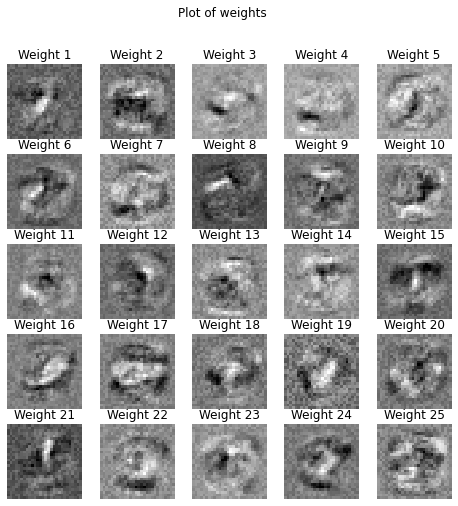

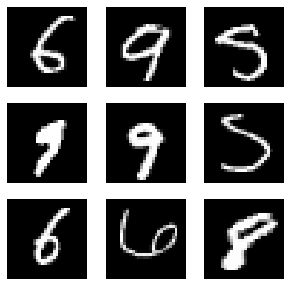

In [69]:
weightsOnly = thetaOneMatrixTrained[:, 1:]


figWeights, axWeights = plt.subplots(5, 5, figsize = (8, 8))
counter = 0
for row in range(0, len(axWeights)):
    for col in range(0, len(axWeights)):
        axWeights[row, col].imshow(weightsOnly[counter,:].reshape(28,28),
                                      cmap = "gray", interpolation = "none")
        axWeights[row, col].set_title("Weight " + str(counter + 1))
        axWeights[row, col].set_axis_off()
        counter += 1
figWeights.suptitle("Plot of weights")

#plot a few digits for comparison:

figDigits, axDigits = plt.subplots(3, 3, figsize = (5,5))
counter = 0
for row in range(0, len(axDigits)):
    for col in range(0, len(axDigits)):
        digit = np.reshape(X_train[counter + np.ceil(np.random.rand() * 10000).astype(int), :], newshape = (28,28))
        axDigits[row, col].imshow(digit, cmap = "gray", interpolation = "none")
        axDigits[row, col].set_axis_off()
        counter += 1
        

## Understanding the weights

It's not too clear what _exactly_ the weights are capturing, but some weights really seem to be capturing specific strokes, just like in the 3Blue1Brown video. For example, weight 5 seems to capture the upward stroke of a 1 or 7, and weight 20 seems to be capturing something vaguely 8-like.

## Convolving filters yourself

The image below is the most exciting image ever to be classified in the history of neural networks. Gaze upon it and weep:
![Square](Square.PNG)
To aid in the monumental task of seeing where the square's edges are, you're going to use convolution. You'll use these two 3\*3 filters for that:
![Filter1](EdgeFilter1.PNG) ![Filter2](EdgeFilter2.PNG)

Here, the values in the cells are the weights for that cell. Remember, to perform a convolution you position the filter over a certain focal pixel, multiply the weights in the filter with the correct underlying pixel values, sum it, add a bias (if using), put that into the activation function (if using) and that's the first entry of your output. Then you slide the filter 1 (or more pixels, if you want) to the right and do it again. If you reach the edge, you move one pixel down and go all the way back to the left, sliding it to the right once more: ![convolution](keras_conv2d_padding.GIF). 

You'll run into trouble at the edges of the image: there the kernel will overlap with non-existent pixels. For this, you use padding, which you already saw in the image above.

Up to you to: 
* Add zero-padding to the square image. You just need 1 row of zeros along the bottom and top, and one column of zeros at the beginning and end of the array. You can do this easily with [np.pad()](https://numpy.org/doc/stable/reference/generated/numpy.pad.html)
* Loop over the columns and rows (in that order) of the image, excepting the first and last column and row. Multiply the values in the first filter with the corresponding pixel intensities in the image, then sum them. Save these values in a new array.
* Do the same for the second filter
* Use `plt.imshow()` with `plt.show()` to visualise your edge detector outputs!
* See if there's any edge detected that you wouldn't want to take into account, and also try to understand why it looks the way it looks!

Hints:
* Remember that Python's from-to function `range` excludes the final value: if you want to go from currentPixel-1 to currentPixel+1 (so 3 pixels), you need (currentPixel-1):(currentPixel+2)
* You should not start at index 0 in your padded image (after all, then the padding has no use!)


(84, 84)


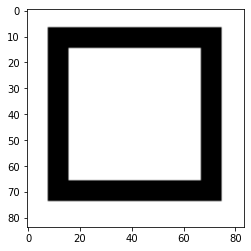

(86, 86)


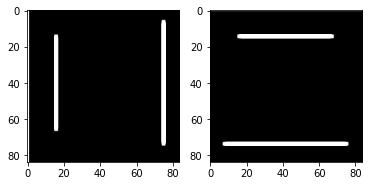

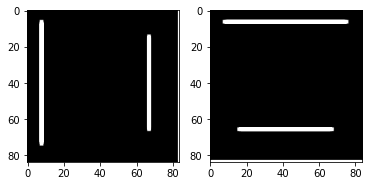

In [57]:
from PIL import Image, ImageOps
squareImage = np.array(ImageOps.grayscale(Image.open("Square.PNG"))) * 1/255
filterOne   = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
filterTwo   = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

print(squareImage.shape)
plt.imshow(squareImage, cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

#answer
squareImageZeroPadded = np.pad(squareImage, 1, "constant", constant_values = 0)
print(squareImageZeroPadded.shape)

filterOneOutput = np.zeros_like(squareImage)
filterTwoOutput = np.zeros_like(squareImage)
for row in range(1, squareImageZeroPadded.shape[0]-1):
    for col in range(1, squareImageZeroPadded.shape[1]-1):
        filterOneOutput[(row-1), (col-1)] = np.sum(squareImageZeroPadded[(row-1):(row+2),(col-1):(col+2)] * filterOne)
        filterTwoOutput[(row-1), (col-1)] = np.sum(squareImageZeroPadded[(row-1):(row+2),(col-1):(col+2)] * filterTwo)

figFilt, axFilt = plt.subplots(1, 2)
axFilt[0].imshow(filterOneOutput, cmap = "gray", vmin = 0, vmax = 1)
axFilt[1].imshow(filterTwoOutput, cmap = "gray", vmin = 0, vmax = 1)

#Strange that one is shorter than the other. Let's invert the filters and see what happens then:
#(Note: this code is not very DRY, but that's because it's extra)
filterThree       = np.flip(filterOne, axis = 1)
filterFour        = np.flip(filterTwo, axis = 0)
filterThreeOutput = np.zeros_like(squareImage)
filterFourOutput  = np.zeros_like(squareImage)
for row in range(1, squareImageZeroPadded.shape[0]-1):
    for col in range(1, squareImageZeroPadded.shape[1]-1):
        filterThreeOutput[(row-1), (col-1)] = np.sum(squareImageZeroPadded[(row-1):(row+2),(col-1):(col+2)] * filterThree)
        filterFourOutput[(row-1), (col-1)]  = np.sum(squareImageZeroPadded[(row-1):(row+2),(col-1):(col+2)] * filterFour)
        
figFiltFlip, axFiltFlip = plt.subplots(1, 2)
axFiltFlip[0].imshow(filterThreeOutput, cmap = "gray", vmin = 0, vmax = 1)
axFiltFlip[1].imshow(filterFourOutput , cmap = "gray", vmin = 0, vmax = 1)

#It's really a function of the corner parts, which, depending on the orientation of the filter, either count or do not. 


## Keras convolutional neural network on MNIST data

An accuracy of 93% on the test set using a dense neural network is nothing to scoff at, but you know that convolutional neural networks (along with other innovations like Dropout and other activation functions) are what made the real leaps in performance possible. Using the Keras library, you can easily train your own convolutional neural network. 

I will discuss Keras in a bit more detail next Monday. For now, you can do the following:

* Go [here](https://keras.io/examples/vision/mnist_convnet/) and input the commands there into the code cell(s) below. You could copy all the code, but typing some of it yourself might give you more of an idea of what you're doing so it's probably preferable.
* As you step through it be sure to search for things you don't know about and think about the dimensionality. What is the total dimensionality of the data after you've run 32 convolutional filters over it? `model.summary()` shows this, but see if you get it.
* As an **optional** question: you could try to get the untrained and trained filter weights and visualise them to see what sort of features in the image each filter has become attuned to. See [this question on Stackoverflow](https://stackoverflow.com/questions/43305891/how-to-correctly-get-layer-weights-from-conv2d-in-keras?noredirect=1&lq=1) and [this link about getting weights from a Keras model](https://www.codespeedy.com/get_weights-and-set_weights-functions-in-keras-layers/).